### Finetuning AlexNet

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" alt="Description of your image">
</div>

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchsummary
import torchvision.transforms as transforms

In [2]:
class AlexNet(nn.Module):
    def __init__(self, number_of_classes):
        super(AlexNet, self).__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 11, padding = 0, stride = 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features = 256 * 6 * 6, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features = 4096, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features = 4096, out_features = number_of_classes),
        )

    def forward(self, x):
        y = self.feats(x)
        y = y.view(y.size(0), -1)
        y = self.classifier(y)
        return y

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
AlexNet = AlexNet(10).cuda()

In [5]:
from torchsummary import summary

# Option 1: Move model to GPU (if you want to use GPU)
AlexNet = AlexNet.cuda()
summary(AlexNet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

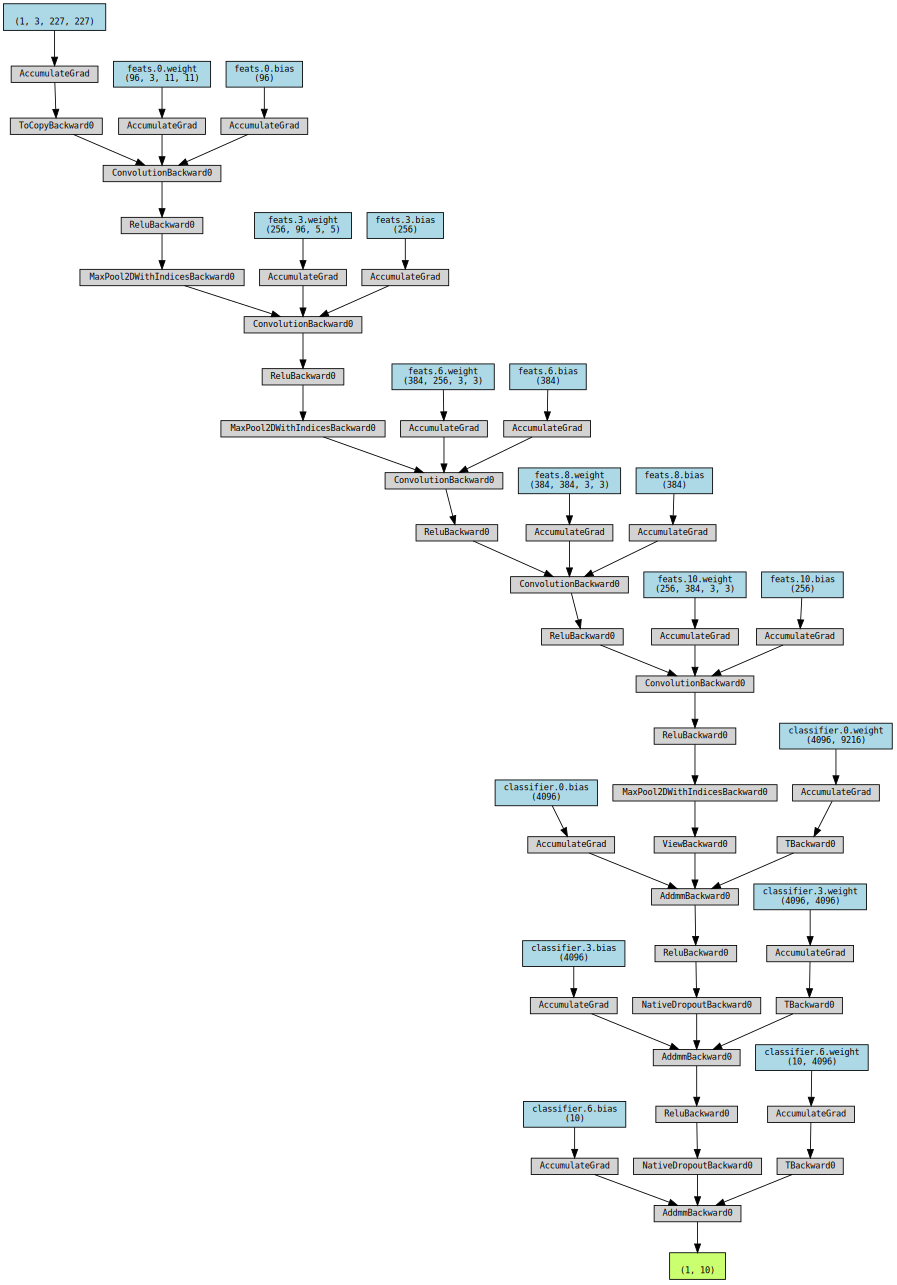

In [6]:
from torchviz import make_dot

x = torch.randn(1, 3, 227, 227).requires_grad_(True).cuda()
y = AlexNet(x)
make_dot(y, params=dict(AlexNet.named_parameters()))

### Importing the pretrained AlexNet

In [7]:
import os
import copy
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

Dataset information
- There are 240 training images and 150 validation images divided equally between the two classes (bees and ants).
- Available on https://www.kaggle.com/ajayrana/hymenoptera-data.

In [8]:
dir = 'hymenoptera_data'

train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]
)

In [9]:
train_datset = datasets.ImageFolder(os.path.join(dir, 'train'), train_transforms)
val_datset = datasets.ImageFolder(os.path.join(dir, 'val'), val_transforms)

In [10]:
AlexNet = models.alexnet(pretrained = True).to(device)

/home/pratyush/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pratyush/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
torchsummary.summary(AlexNet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [12]:
print(AlexNet.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [13]:
# Add a new classifier layer

AlexNet.classifier[6] = nn.Linear(4096, 2).to(device)

In [14]:
torchsummary.summary(AlexNet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [15]:
train_loader = torch.utils.data.DataLoader(train_datset, batch_size = 4, shuffle = True)

In [16]:
def finetune_model(model, train_dataset, val_dataset, epochs, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) # Observe that all parameters are being optimized
    scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) # Decay LR by a factor of 0.1 every 7 epochs
    best_model_wts = copy.deepcopy(model.state_dict()) # Initialize the model with the best weights
    best_acc = 0.0 # Initialize the best accuracy

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_acc = 0

            for input, label in torch.utils.data.DataLoader(train_dataset if phase == 'train' else val_dataset, batch_size = 4, shuffle = True):
                input = input.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, label)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * input.size(0) # Multiply the loss by the number of inputs
                running_acc += torch.sum(pred == label.data) # Sum the number of correct predictions

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
            epoch_acc = running_acc.double() / len(train_dataset if phase == 'train' else val_dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)

    return model

In [17]:
finetuned_AlexNet = finetune_model(AlexNet, train_datset, val_datset, 25, device)

Epoch 1/25
----------
train Loss: 0.7550 Acc: 0.6557
val Loss: 0.6580 Acc: 0.6601

Epoch 2/25
----------
train Loss: 0.7012 Acc: 0.6557
val Loss: 0.5809 Acc: 0.7451

Epoch 3/25
----------
train Loss: 0.5140 Acc: 0.7705
val Loss: 0.6945 Acc: 0.7451

Epoch 4/25
----------
train Loss: 0.5729 Acc: 0.7336
val Loss: 0.5452 Acc: 0.7320

Epoch 5/25
----------
train Loss: 0.5594 Acc: 0.6926
val Loss: 0.4901 Acc: 0.7647

Epoch 6/25
----------
train Loss: 0.5304 Acc: 0.7623
val Loss: 0.4426 Acc: 0.7843

Epoch 7/25
----------
train Loss: 0.4491 Acc: 0.7828
val Loss: 0.3725 Acc: 0.8235

Epoch 8/25
----------
train Loss: 0.3653 Acc: 0.8361
val Loss: 0.3051 Acc: 0.8954

Epoch 9/25
----------
train Loss: 0.2706 Acc: 0.8730
val Loss: 0.2792 Acc: 0.9020

Epoch 10/25
----------
train Loss: 0.2496 Acc: 0.8975
val Loss: 0.2759 Acc: 0.8954

Epoch 11/25
----------
train Loss: 0.2378 Acc: 0.8934
val Loss: 0.2750 Acc: 0.8954

Epoch 12/25
----------
train Loss: 0.2342 Acc: 0.8811
val Loss: 0.2618 Acc: 0.9150

E

In [18]:
finetuned_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
torch.save(finetuned_AlexNet.state_dict(), 'finetuned_AlexNet.pth')

In [20]:
torchsummary.summary(finetuned_AlexNet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

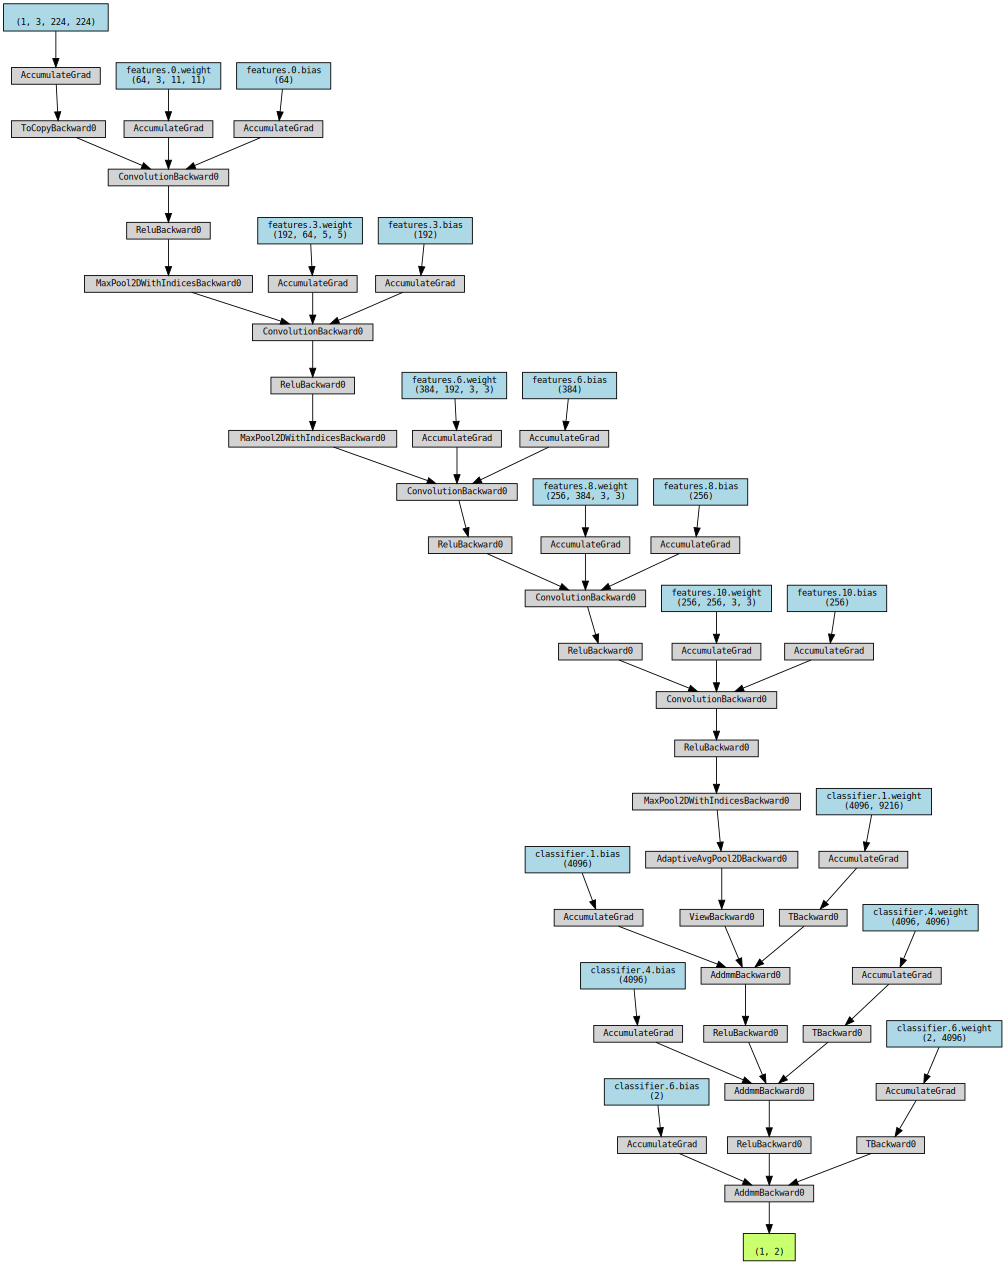

In [21]:
make_dot(finetuned_AlexNet(torch.randn(1, 3, 224, 224).requires_grad_(True).to(device)), params=dict(finetuned_AlexNet.named_parameters()))

Accuracy of the network on the 153 test images: 91.50326797385621%


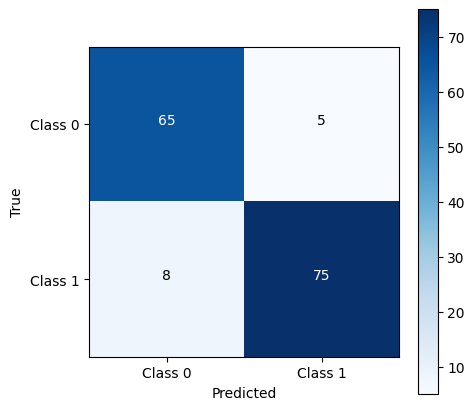

In [22]:
import numpy as np

def report_accuracy(model, dataset, device):
    model.eval()
    correct = 0
    total = 0
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        for inputs, labels in torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

    # Convert confusion matrix to NumPy array
    confusion_matrix = confusion_matrix.numpy()

    # Draw the confusion matrix using matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Display the values in the confusion matrix
    thresh = confusion_matrix.max() / 2.
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, int(confusion_matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.show()

# Example usage
report_accuracy(finetuned_AlexNet, val_datset , device)